# ML.py, MLpy, MLPy!
<p style="text-align: center;">MLpy came as a simple question and a project in pespective:
<br><b>"Can I build a discord bot that can tell two pictures apart?"</b></p>
<br>The goal of this Jupyter Notebook is two-fold with one overarching thread:

1. To use a self-made [web scraper](https://github.com/LMquentinLR/derpi_get) that can crawl, if not all, a statistically relevant number of images from [derpibooru](https://derpibooru.org), a linear image database powered by the community revolving around the 'My Little Pony' cartoon.
2. To build a machine learning model capable of telling the difference between 2 types of pictures--to be summarized in a function to implement in my existing Discord bot [BotJack](https://github.com/LMquentinLR/botjack_discord_bot).

### Why image detection for a Discord bot?
<p style="text-align: center;"><b>Discord moderation is hard</b>.</p>

Any Discord moderation team will tell you that. As such, automating as much as possible the <i>mundane stuff</i> is great. A moderation team for instance may want to identify images posted by users on their server. This may have multiple purposes: classification, tagging, games, etc.

<p style="text-align: center;">This notebook will focus on <b>compliance</b>.</p> 

* Servers often have anti-NSFW (i.e. not safe for watch) rules where explicit, grim, and otherwise unwanted content is banned or curtailed to specific server channels.
* Moderation being volunteer-driven on Discord, malicious users may capitalize on idle, asleep, or away-from-keyboard moderators to engage in rule-breaking activities. More commonly, users may simply post a NSFW picture in a SFW-only channel. 
* A bot able to distinguish NSFW content from SFW helps fill in the gaps that may affect any moderation effort. A bot, for instance, could automatically alert moderators whenever a specific content is posted. And in case, it may even start a moderation process prior to any human intervention.

This topic also has an actual application "IRL":
> <b>Automatic content moderation and compliance is a current industry effort among social media companies (e.g. Facebook)</b>

In [1]:
# Importing the necessary modules

import collections
import derpi_get
import datetime
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.layers import GaussianNoise
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
from random import shuffle
import shutil

Using TensorFlow backend.


------------------

# Crawling Derpibooru Using the derpi_get module
Using the derpi_get module available [here](https://github.com/LMquentinLR/derpi_get), we download an exhaustive selection of Derpibooru's picture metadata (i.e. all of it).
### Why building a web scraper?
Derpibooru is a website dedicated to MLP fanart. It provides a REST API for rudimentary site functionality, and can be freely used by anyone wanting to produce tools for the site or other webapps that use Derpibooru-provided data.

<b>Derpibooru licensing rules:</b>
"<i>Anyone can use it, users making abusively high numbers of requests may be asked to stop. Your application MUST properly cache, respect server-side cache expiry times. Your client MUST gracefully back off if requests fail (eg non-200 HTTP code), preferably exponentially or fatally.</i>"

A single image can be accessed through the following links:
1. <b>Embedded</b>: [../2072316](https://derpibooru.org/2072316)
2. <b>Default size</b>: [../img/view/2019/6/22/2072316.png](https://derpicdn.net/img/view/2019/6/22/2072316.png) 
3. <b>Small size</b>: [../img/view/2019/6/22/2072316_small.png](https://derpicdn.net/img/view/2019/6/22/2072316_small.png)
4. <b>Medium size</b>: [../img/view/2019/6/22/2072316_medium.png](https://derpicdn.net/img/view/2019/6/22/2072316_medium.png)
5. <b>Large size</b>: [../img/view/2019/6/22/2072316_large.png](https://derpicdn.net/img/view/2019/6/22/2072316_large.png)

The metadata of a single picture can be accessed through the following link:
* https://derpibooru.org/2072316.json

Each picture as the following list of attributes:
>id, created_at, updated_at, first_seen_at, score, comment_count, width, height, file_name, description, uploader, uploader_id, image, upvotes, downvotes, faves, tags, tag_ids, aspect_ratio, original_format, mime_type, sha512_hash, orig_sha512_hash, source_url, representations, is_rendered, is_optimized, interactions, spoilered

In [2]:
#Initializing the scraper object
obj = derpi_get.derpibooru_search()

In [3]:
obj.change_search(instances = "") #switch to instances = "" for a full crawl of derpibooru
obj.crawl()

----|Entering Derpibooru Data Crawler code|----
FILE FOUND: 'derpibooru_metadata.json'
You are requesting the derpibooru page starting with the id 2190529.
You are requesting the derpibooru page starting with the id 2190555.
You are requesting the derpibooru page starting with the id 2190580.
You are requesting the derpibooru page starting with the id 2190605.
You are requesting the derpibooru page starting with the id 2190631.
You are requesting the derpibooru page starting with the id 2190656.
You are requesting the derpibooru page starting with the id 2190681.
You are requesting the derpibooru page starting with the id 2190685.
The crawler scraped the derpibooru metadata. The program will now close.
---------------|Exiting Program|---------------


From time to time, retrieved metadata (as a JSON) would be missing tags value. The following method checks for existing missing tags and retrieve them from derpibooru. It acts as a repair method.

In [4]:
obj.repair()

----|Repairing missing tags in stored JSON|----
----------------|Tags repaired|----------------


## Retrieving IDs based on tag selection

The search function retrieve_ids() of the derpi_get module takes a list of strings that corresponds to picture tags. Each tag must have a prefix, either "<b>+</b>" or "<b>-</b>".

> A "<b>+</b>" prefix indicates that IDs with said tag will be kept

> A "<b>-</b>" prefix indicates that IDs with said tag will be discarded

The object "obj" has a variable called "<b>at_least_one</b>". It is a boolean value so that:
1. if <b>TRUE</b>: Only the IDs which tags <b>contain at least one</b> of the items listed in the variable "<b>tags</b>" with a "+" prefix will be retrieved
2. if <b>FALSE</b>: Only the IDs which tags <b>contain all</b> of the items listed in the variable "<b>tags</b>" with a "+" prefix will be retrieved

## Case Use of derpi_get.retrieve_ids(): Data Exploration Using MatPlotlib

#### What do we want to plot?

> number of pictures pertaining to each five of major ships with one of the main characters of the show.

In [5]:
ship_ids = {"+rarijack":[],"+rarilight":[],"+flarity":[],"+raridash":[],"+raripie":[]}
for ship in ship_ids:
    print(ship)
    obj.change_search(tags = [ship], at_least_one = False)
    ship_ids[ship] = obj.retrieve_ids()
    print("Number of retrieved items: ", len(ship_ids[ship]))
    print("\nFirst item retrieved:")
    print(ship_ids["+rarijack"][0])

+rarijack
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  6113

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+rarilight
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1592

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+flarity
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1354

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+raridash
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retrieved items:  1775

First item retrieved:
(2190599, 'derpicdn.net/img/2019/11/8/2190599/large.png')
+raripie
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
Number of retri

### MatplotLib

In [6]:
def create_dataframe(name, data):
    """
    Creates the dataframe containing the data for each pairing in ships
    -----
    :param <name>: str ; name of pairing
    :param <data>: lists ; list of tuples containing the pairing data 
    """
    datelist = []
    for entry in data:
        url_split = entry[1].split("/")
        url_split = list(map(int, url_split[-5: -2]))
        datelist.append(datetime.date(url_split[0], url_split[1], url_split[2]))
    shipping_data = pd.DataFrame(data=dict(collections.Counter(datelist)).values(),
                                 index=collections.Counter(datelist))
    shipping_data.sort_index(inplace=True)
    shipping_data.index = pd.to_datetime(shipping_data.index)
    shipping_data = shipping_data.reindex(pd.date_range(shipping_data.index[0],shipping_data.index[-1]), 
                                          fill_value=0)
    shipping_data[1] = shipping_data.cumsum()
    shipping_data.columns = [name, "Cumulative Sum"]
    return shipping_data

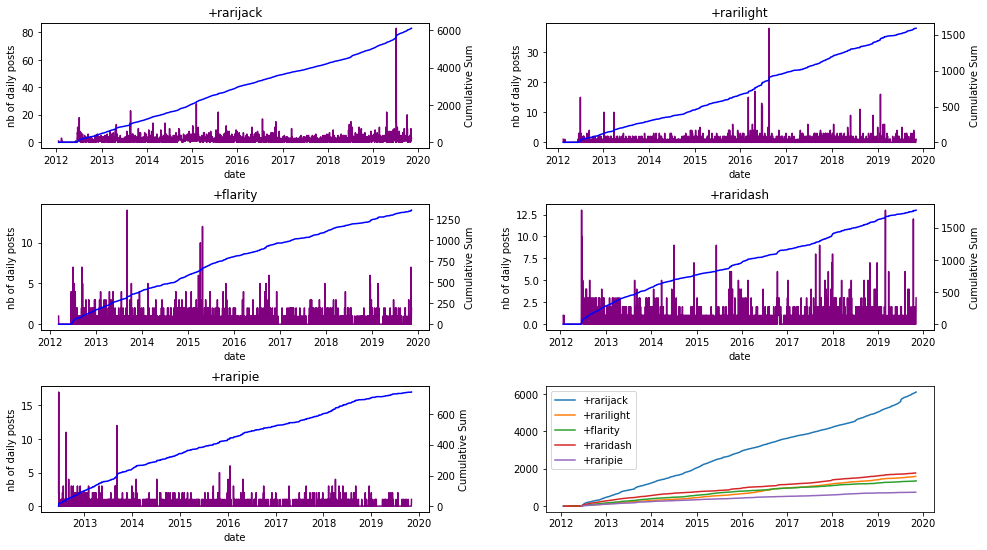

In [7]:
years = mdates.YearLocator() #every year
yearsFmt = mdates.DateFormatter("%Y")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 9))
fig.subplots_adjust(hspace=.45, wspace=.3)

counter = 0
for i in range(3):
    for j in range(2):
        if i * j != 2:
            df = create_dataframe(list(ship_ids.keys())[counter], ship_ids[list(ship_ids.keys())[counter]])
            axes[i, j].set_title(list(ship_ids.keys())[counter])
            axes[i, j].plot(df.index, 
                            df[list(ship_ids.keys())[counter]].values, 
                            color="purple", 
                            label=list(ship_ids.keys())[counter])
            ax2 = axes[i, j].twinx()
            ax2.plot(df.index, 
                     df["Cumulative Sum"].values, 
                     color="blue")
            ax2.set_ylabel("Cumulative Sum")
            axes[i, j].set_xlabel("date")
            axes[i, j].set_ylabel("nb of daily posts")
            axes[i, j].xaxis.set_major_locator(years)
            axes[i, j].xaxis.set_major_formatter(yearsFmt)
            axes[2, 1].plot(df.index, df["Cumulative Sum"].values,
                            label=list(ship_ids.keys())[counter])
        counter += 1

axes[2, 1].xaxis.set_major_locator(years)
axes[2, 1].xaxis.set_major_formatter(yearsFmt)
axes[2, 1].legend()
plt.savefig('shipping_chart.png')

# SEPARATING SFW FROM NSFW PICTURES

## Downloading pictures

We need to download a set of pictures which can be used to fit a machine learning model.

In [8]:
def download(tag_lists, nb_of_requests):
    """
    Downloads pictures based on a list of tag.
    ---
    :param <tags>: list ; list of tags to sort and download pictures
    :param <nb_of_requests>: int ; number of download requests to perform
    """
    obj = derpi_get.derpibooru_search()
    for tags in tag_lists:
        obj.change_search(tags = tags, at_least_one = True)
        id_list = obj.retrieve_ids()
        obj.request_imgs(tags, id_list, nb_of_requests)

In [9]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "+suggestive", "+questionable", "-comic", "-meme", "-text"]]

In [ ]:
download(tags, 11000)

## Running Machine Learning

### Creating samples

Based on all the extracted pictures--and to make the process run in a timely manner on my Surface Pro 2--we are sampling the extracted data:

- 6400 safe and unsafe pictures for training
- 1600 safe and unsafe pictures for testing/validation

In [11]:
model_description = [("./data/train/Training", 6400),
                     ("./data/train/Test", 1600)]
img_size = 256

In [12]:
def create_sample(folders, model_description):
    """
    Samples existing pictures.
    ---
    :param <folders>: list ; list of folders to sample
    :param <model_description>: list ; list of folders where to store samples 
                                + nb of pictures to extract
    """
    counter = 0
    selection = []
    
    # checks if training and testing folders exists
    # creates them if not, deletes then recreates if they exist
    for model in model_description:
        target_folder = model[0]
        try:
            shutil.rmtree(target_folder)
        except Exception as e: 
            print(e)
        os.makedirs(target_folder)
        
        # for safe then unsafe pictures, populates training then testing folders
        for folder in folders:
            counter = 0
            stored_imgs = os.listdir(folder)
            while counter <= model[1]:
                choice = random.choice(stored_imgs)
                if choice not in selection:
                    selection.append(choice) #an ID canot be reused
                    shutil.copy(folder + "/" + choice, target_folder)
                    os.rename(target_folder + "/" + choice,
                             target_folder + "/" + folder[7:].split("-")[0]
                             + "-" + choice)
                    counter += 1

In [13]:
def label_img(name):
    """
    Returns whether an image is safe or unsafe based on its name.
    ---
    :param <name>: string ; path/name of a picture
    """
    word_label = name.split('-')[0]
    if word_label.startswith("+safe"): 
        return np.array([1, 0])
    else: 
        return np.array([0, 1])

In [14]:
def load_data(folder, img_size):
    """
    Loads the safe/unsafe value of each picture stored in a specific folder.
    ---
    :param <filder>: string ; path of a folder
    :param <img_size>: int ; width and height of every image to be trained on/tested
    """
    data = []
    for img in os.listdir(folder):
        label = label_img(img)
        path = os.path.join(folder, img)
        img = Image.open(path)
        img = img.convert('L') #grayscale
        img = img.resize((img_size, img_size), Image.ANTIALIAS)
        data.append([np.array(img), label])
    shuffle(data)
    return data

In [16]:
folders = ["./data/+safe-comic-meme-text", 
                  "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
create_sample(folders, model_description)

[WinError 3] The system cannot find the path specified: './data/train/Training'
[WinError 3] The system cannot find the path specified: './data/train/Test'


The code below is a rewrite of the following github: [here](https://github.com/CShorten/KaggleDogBreedChallenge/blob/master/DogBreed_BinaryClassification.ipynb?source=post_page---------------------------).
Thanks to CShorten!

In [17]:
DIR_TRAINING = model_description[0][0]
DIR_TESTING = model_description[1][0]

In [18]:
train_data = load_data(DIR_TRAINING, img_size)
#plt.imshow(train_data[0][0], cmap = 'gist_gray') #Shows an example
trainImages = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1) #Flattens
trainLabels = np.array([i[1] for i in train_data])

c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [19]:
test_data = load_data(DIR_TESTING, img_size)    
#plt.imshow(test_data[0][0], cmap = 'gist_gray') #Shows an example
testImages = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1) #Flattens
testLabels = np.array([i[1] for i in test_data])

### Machine Learning Modeling

In [33]:
model = Sequential()
model.add(Conv2D(64, kernel_size = (5,5), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation = 'softmax'))

In [34]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics = ['accuracy'])

### Training #1

<b>Batch size</b>: 32

<b>Epoch</b>: 5

In [25]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 5,
          verbose = 1)

Epoch 1/5
12802/12802 [==============================] - 1979s 155ms/step - loss: 0.7135 - acc: 0.5650
Epoch 2/5
12802/12802 [==============================] - 1915s 150ms/step - loss: 0.6571 - acc: 0.6113
Epoch 3/5
12802/12802 [==============================] - 1908s 149ms/step - loss: 0.6349 - acc: 0.6365
Epoch 4/5
12802/12802 [==============================] - 1901s 148ms/step - loss: 0.6148 - acc: 0.6588
Epoch 5/5
12802/12802 [==============================] - 1863s 145ms/step - loss: 0.5937 - acc: 0.6803


In [26]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

61.43035602748282


In [27]:
model.save('NSFWdetect_v1_5ep_32b_5CL_2FC.h5')

### Training #2

<b>Batch size</b>: 32

<b>Epoch</b>: 10

In [30]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 10,
          verbose = 1)

Epoch 1/10
12802/12802 [==============================] - 1879s 147ms/step - loss: 0.7076 - acc: 0.5612
Epoch 2/10
12802/12802 [==============================] - 1872s 146ms/step - loss: 0.6564 - acc: 0.6074
Epoch 3/10
12802/12802 [==============================] - 1861s 145ms/step - loss: 0.6402 - acc: 0.6344
Epoch 4/10
12802/12802 [==============================] - 1860s 145ms/step - loss: 0.6186 - acc: 0.6631
Epoch 5/10
12802/12802 [==============================] - 1858s 145ms/step - loss: 0.6065 - acc: 0.6679
Epoch 6/10
12802/12802 [==============================] - 1869s 146ms/step - loss: 0.5832 - acc: 0.6887
Epoch 7/10
12802/12802 [==============================] - 1861s 145ms/step - loss: 0.5675 - acc: 0.7052
Epoch 8/10
12802/12802 [==============================] - 1867s 146ms/step - loss: 0.5587 - acc: 0.7108
Epoch 9/10
12802/12802 [==============================] - 1856s 145ms/step - loss: 0.5382 - acc: 0.7247
Epoch 10/10
12802/12802 [==============================] - 1864s

In [31]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

67.30168644597127


In [32]:
model.save('NSFWdetect_v1_10ep_32b_5CL_2FC.h5')

### Training #3

<b>Batch size</b>: 32

<b>Epoch</b>: 20

In [35]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
12802/12802 [==============================] - 2008s 157ms/step - loss: 0.7089 - acc: 0.5614
Epoch 2/20
12802/12802 [==============================] - 2226s 174ms/step - loss: 0.6615 - acc: 0.5998
Epoch 3/20
12802/12802 [==============================] - 2267s 177ms/step - loss: 0.6422 - acc: 0.6256
Epoch 4/20
12802/12802 [==============================] - 2289s 179ms/step - loss: 0.6266 - acc: 0.6477
Epoch 5/20
12802/12802 [==============================] - 2171s 170ms/step - loss: 0.6139 - acc: 0.6580
Epoch 6/20
12802/12802 [==============================] - 1903s 149ms/step - loss: 0.5953 - acc: 0.6825
Epoch 7/20
12802/12802 [==============================] - 1902s 149ms/step - loss: 0.5775 - acc: 0.6955
Epoch 8/20
12802/12802 [==============================] - 1902s 149ms/step - loss: 0.5582 - acc: 0.7131
Epoch 9/20
12802/12802 [==============================] - 1897s 148ms/step - loss: 0.5403 - acc: 0.7299
Epoch 10/20
12802/12802 [==============================] - 1890s

In [36]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

70.45596502186133


In [37]:
model.save('NSFWdetect_v1_20ep_32b_5CL_2FC.h5')